# Mixed layer budgets

In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt, dates
from cartopy import crs, feature
from datetime import datetime
from scipy.interpolate import interp1d
from tqdm import tqdm

plt.rcParams.update({'font.size': 14, 'axes.titlesize': 'medium'})

***

## Mixed layer salinity budget

### Budget formulation

Start by integrating the salinity transport equation over the mixed layer control volume

$$\int_V\left[\frac{\partial S}{\partial t} + \nabla\cdot\left(\vec{\mathbf{v}}S\right) + \nabla\cdot\left(\overline{\vec{\mathbf{v}}'S'}\right)\right]dV = 0$$

(1) $D/Dt$ term (Reynolds Transport Theorem)

$$
\begin{align}
\int_V\left[\frac{\partial S}{\partial t} + \nabla\cdot\left(\vec{\mathbf{v}}S\right)\right]dV & = \frac{d}{dt}\int_VSdV + \int_{\partial V}S(\vec{\mathbf{v}} - \vec{\mathbf{v}}_r)\cdot\hat{\mathbf{n}}dA\\[12pt]
& = \frac{d}{dt}\int_VSdV + \int_{sides}\left(\vec{\mathbf{v}}_HS\right)\cdot\hat{\mathbf{n}}_HdA + \int_{bot}\bigg[\left(\vec{\mathbf{v}}_HS\right)\cdot\nabla z - S(w - w_r)\bigg]dA
\end{align}
$$

(2) Diffusion term (Gauss's Theorem)

$$
\begin{align}
\int_V\nabla\cdot\left(\overline{\vec{\mathbf{v}}'S'}\right)dV & = \int_{\partial V}\left(\overline{\vec{\mathbf{v}}'S'}\right)\cdot\hat{\mathbf{n}}dA\\[12pt]
& = \int_{sides}\left(\overline{\vec{\mathbf{v}}_H'S'}\right)\cdot\hat{\mathbf{n}}_HdA + \int_{bot}\bigg[\left(\overline{\vec{\mathbf{v}}_H'S'}\right)\cdot\nabla z - \overline{w'S'}\bigg]dA + \int_{top}\overline{w'S'}dA
\end{align}
$$

**Budget Equation**

$$\boxed{\vphantom{\rule{0pt}{22pt}}\hspace{12pt}\underbrace{\frac{d}{dt}\int_VSdV}_{\textbf{Residual}} = -\underbrace{\int_{sides}\left(\vec{\mathbf{v}}_HS + \overline{\vec{\mathbf{v}}_H'S'}\right)\cdot\hat{\mathbf{n}}_HdA}_{\textbf{Horz Adv+Diff Sides}} - \underbrace{\int_{bot}\left(\vec{\mathbf{v}}_HS + \overline{\vec{\mathbf{v}}_H'S'}\right)\cdot\nabla zdA}_{\textbf{Horz Adv+Diff Bottom}} + \underbrace{\int_{bot}S(w - w_r)dA}_{\textbf{Vert Adv+Ent Bottom}} + \underbrace{\int_{bot}\overline{w'S'}dA}_{\textbf{Vert Diff Bottom}} - \underbrace{\int_{top}\overline{w'S'}dA}_{\textbf{Surface}}\hspace{12pt}}$$

***

### Terms

   - **Residual** We can't directly calculate this, but we can plot the change in Monthly ML-averaged salinity to see if it's at all close
   - **Horz Adv + Diff Sides** Monthly cell salinity tendency terms integrated over region and mixed layer (Gauss: interior divergence equals edge transport)
   - **Horz Adv + Diff Bottom** Monthly edge flux terms interpolated to the ML base, multiplied by the ML tilt across the edge (*we only have adv, no diff*)
   - **Vert Adv + Ent Bottom** Monthly vertical salinity flux terms interpolated to the ML base. 5-day ML snapshots from HF outputs for calculating $w_r$.
   - **Vert Diff Bottom** Monthly vertical diffusivity interpolated to the ML base, multplied by the vertical salinity gradient calculated by the cell-centered difference that spans the ML.
   - **Surface** Monthly nonlocal salinity flux, which is equal to the surface salinity flux that we calculate in WMT (I checked)

***

## LR Budget Calculation

### Set up

Functions

In [2]:
def get_edge_signs(nCells, cellsOnEdge, edgesOnCell):
    """
    """
    
    # Build edge signs
    isNegative = cellsOnEdge[edgesOnCell, 0] == nCells
    edgeSignOnCell = np.where(isNegative, -1, 1)
    
    return edgeSignOnCell


def remap2edge(variable, cellsOnEdge):
    """Remap variable to edge by averaging cells on either side
    """
    
    # Remap to edge by averaging cells on either side
    neighbors = [variable[col] for col in cellsOnEdge.T]
    variable_remapped = (neighbors[0] + neighbors[1]) / 2
    
    return variable_remapped


def interp(Y, X, Xi):
    """Interpolation wrapper
    """

    # Interpolate
    Yi = []
    for y, x, xi, maxLevel in zip(Y, X, Xi, coords['maxLevelCell']):
        valid = np.isfinite(x)
        try:
            yi = interp1d(x[valid], y[valid])(xi)
        except ValueError:
            yi = y[maxLevel - 1]
        Yi.append(yi)
    
    return np.array(Yi)


def get_depths(H):
    """
    """

    zeros = np.zeros((len(H), 1))
    H[H == 0] = np.nan
    depths = {'interface': np.hstack([zeros, np.cumsum(H, axis=1)])}
    depths['midpoint'] = (depths['interface'][:, :-1] + depths['interface'][:, 1:]) / 2

    return depths


def get_MLD_index(depth, MLD):
    """
    """

    # Get MLD index
    mask = (depth - MLD[:, None]) > 0
    valid = np.any(mask, axis=1)
    idx = (mask).argmax(axis=1) - 1

    return idx, valid

Paths, mask, mesh, constants, variable names

In [3]:
# Init coords
coordinates = {}

In [5]:
# Build results prefix
paths = {
    'LR': {
        'mesh': '/global/cfs/projectdirs/e3sm/inputdata/ocn/mpas-o/EC30to60E2r2/ocean.EC30to60E2r2.210210.nc',
        'mask': '/pscratch/sd/b/bmoorema/maskfiles/EC30to60E2r2_transformationbudgetmasks20240724.nc',
        'results': '/pscratch/sd/b/bmoorema/run_001_062/20210421_sim7_CORE_60to30E2r2.mpaso.hist.am',
    },
    'HR': {
        'mesh': '/global/cfs/projectdirs/e3sm/inputdata/ocn/mpas-o/oRRS18to6v3/oRRS18to6v3.171116.nc',
        'mask': '/pscratch/sd/b/bmoorema/maskfiles/oRRS18to6v3_transformationbudgetmasks20240724.nc',
        'results': '/global/cfs/cdirs/m4259/lvroekel/run_001_010/20210421_sim7_CORE_18to6v3.mpaso.hist.am',
    }
}

meshName = 'LR'

# Load mask
ds = xr.open_dataset(paths[meshName]['mask'])
idx = ds.regionNames.astype(str) == 'Labrador Sea'
regionMask, = np.where(ds.regionCellMasks[:, idx][:, 0].values.astype(bool))

# Load mesh
ds = xr.open_dataset(paths[meshName]['mesh'])
nCells = ds.nCells.values
nVertLevels = ds.nVertLevels.values
maxEdges = ds.maxEdges.values
cellsOnEdge = ds.cellsOnEdge.values - 1
edgesOnCell = ds.edgesOnCell.values - 1
dvEdge = ds.dvEdge.values
areaCell = ds.areaCell.values[regionMask]
maxLevelCell = ds.maxLevelCell.values[regionMask]
lonCell = np.rad2deg(ds.lonCell.values[regionMask])
latCell = np.rad2deg(ds.latCell.values[regionMask])
lonCell = np.where(lonCell > 180, lonCell - 360, lonCell)

# Get edge signs, then apply regionMask
edgeSignOnCell = get_edge_signs(nCells[:, None], cellsOnEdge, edgesOnCell)
edgesOnCell, edgeSignOnCell = edgesOnCell[regionMask], edgeSignOnCell[regionMask]

# Package into coords dict
coordinates[meshName] = {
    'regionMask'     : regionMask,
    'nCells'         : len(regionMask),
    'nVertLevels'    : nVertLevels,
    'maxEdges'       : len(maxEdges),
    'cellsOnEdge'    : cellsOnEdge,
    'edgesOnCell'    : edgesOnCell,
    'edgeSignOnCell' : edgeSignOnCell,
    'dvEdge'         : dvEdge,
    'areaCell'       : areaCell,
    'maxLevelCell'   : maxLevelCell,
    'lonCell'        : lonCell,
    'latCell'        : latCell,
}

# Constants
dt = 86400 * 5    # highFrequencyOutput interval [s]
rho_sw = 1026.0   # Seawater density constant [kg m-3]
rho_fw = 1000.0   # Freshwater density constant [kg m3]

# Variable names
prefix = 'timeMonthly_avg_'
varNames = {
    'MLD'           : ['cell', 'dThreshMLD'],
    'H'             : ['cell', 'layerThickness'],
    'Kappa'         : ['cell', 'vertDiffTopOfCell'],
    'S'             : ['cell', 'activeTracers_salinity'],
    'HorzAdvTend'   : ['cell', 'activeTracerHorizontalAdvectionTendency_salinityHorizontalAdvectionTendency'],
    'HorzMixTend'   : ['cell', 'activeTracerHorMixTendency_salinityHorMixTendency'],
    'HorzAdvTendML' : ['cell', 'activeTracerHorAdvectionMLTend_salinityHorAdvectionMLTend'],
    'HorzMixTendML' : ['cell', 'activeTracerHorMixMLTend_salinityHorMixMLTend'],
    'HorzAdvFlux'   : ['edge', 'activeTracerHorizontalAdvectionEdgeFlux_salinityHorizontalAdvectionEdgeFlux'],
    'VertAdvFlux'   : ['cell', 'activeTracerVerticalAdvectionTopFlux_salinityVerticalAdvectionTopFlux'],
    'NonLocal'      : ['cell', 'nonLocalSurfaceTracerFlux_nonLocalSalinitySurfaceFlux'],
    'Evaporation'   : ['cell', 'evaporationFlux'],
    'Rain'          : ['cell', 'rainFlux'],
    'Snow'          : ['cell', 'snowFlux'],
    'River'         : ['cell', 'riverRunoffFlux'],
    'IceRunoff'     : ['cell', 'iceRunoffFlux'],
    'SeaIceFW'      : ['cell', 'seaIceFreshWaterFlux'],
    'SeaIceS'       : ['cell', 'seaIceSalinityFlux'],
    'Restoring'     : ['cell', 'salinitySurfaceRestoringTendency'],
}

Show map of masked region

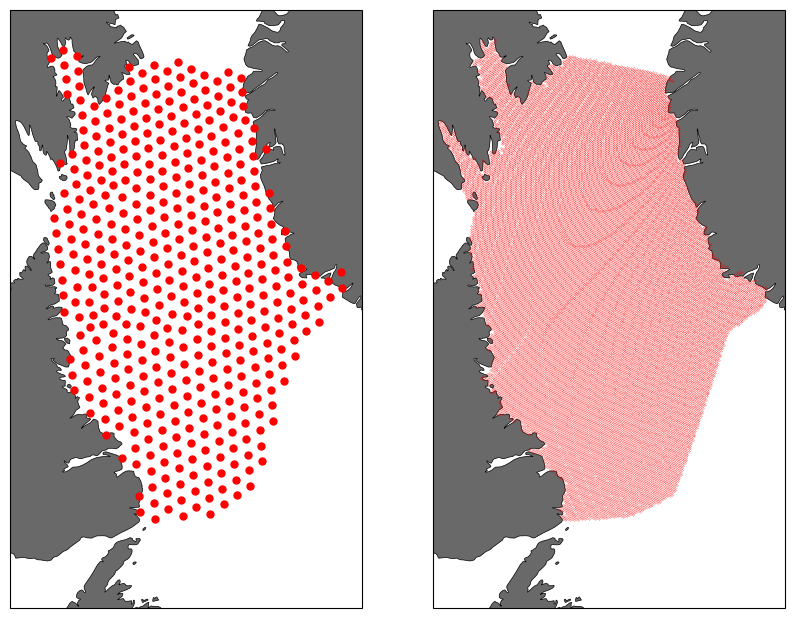

In [6]:
# Show map of regionCellMask
proj, proj_ref = crs.LambertConformal(-40, 20), crs.PlateCarree()
kwargs = dict(color='dimgray', edgecolor='k', linewidth=0.5)
fig, axs = plt.subplots(1, 2, figsize=(10, 10), subplot_kw={'projection': proj})
for ax, meshName, ms in zip(axs, ['LR', 'HR'], [5, 0.2]):
    coords = coordinates[meshName]
    ax.set_extent([-62, -45, 50, 68])
    ax.add_feature(feature.NaturalEarthFeature('physical', 'land', '50m', **kwargs))
    ax.plot(coords['lonCell'], coords['latCell'], 'ro', ms=ms, transform=proj_ref)

***

### Test horizontal advection

Check consistency between edge advection and cell tendency methods for calculating horizontal advection

In [7]:
# Load horizontal advection variables
meshName = 'LR'
coords = coordinates[meshName]
variables = {}
ds = xr.open_dataset(f"{paths[meshName]['results']}.timeSeriesStatsMonthly.0001-01-01.nc")
for name in ['H', 'MLD', 'HorzAdvFlux', 'HorzAdvTend', 'HorzAdvTendML']:
    variables[name] = ds[prefix + varNames[name][1]][0, ...].values

# Iterpolate layerThickness to edge
H_edge = remap2edge(variables['H'], coords['cellsOnEdge'])

# Apply regionMask
for name in ['H', 'MLD', 'HorzAdvTend', 'HorzAdvTendML']:
    variables[name] = variables[name][coords['regionMask']]

# Get interface and midpoint depths from layerThickness
variables.update(get_depths(variables['H']))

# Integrate terms over cell edges
HorzAdvFlux = variables['HorzAdvFlux'] * coords['dvEdge'][:, None]
HorzAdvTend = variables['HorzAdvTend'] * coords['areaCell'][:, None]
HorzAdvFluxH = HorzAdvFlux * H_edge
HorzAdvTendH = HorzAdvTend * variables['H']
HorzAdvTendML_avg = np.sum(variables['HorzAdvTendML'] * variables['MLD'] * coords['areaCell']) * 1e-6

# Get the depth indexes of the layer below the ML
idx, valid = get_MLD_index(variables['interface'], variables['MLD'])
idx[~valid] = coords['maxLevelCell'][~valid]

# Get ML fluxes
# -- Uses full layer depth at the ML base because interpolating
# -- the partial thickness to the edges does weird stuff
maskCell = coords['nVertLevels'][None, :] <= idx[:, None] # <= includes ML_bot
HorzAdvFluxML = []
for layer, mask in zip(HorzAdvFluxH.T, maskCell.T):
    edges, signs = coords['edgesOnCell'][mask], coords['edgeSignOnCell'][mask]
    edgesBad = edges < 0
    edges, signs = edges[~edgesBad], signs[~edgesBad]
    layersum = np.nansum((layer[edges] * signs))
    HorzAdvFluxML.append(layersum)
HorzAdvFluxML = np.nansum(HorzAdvFluxML) * 1e-6

# Get ML tendency
# -- uses partial layer depth at the ML base
maskCell = coords['nVertLevels'][None, :] < idx[:, None] # < excludes ML_bot
HorzAdvTendML = np.sum(HorzAdvTendH[maskCell])

# Get ML tendency fraction of the bottom layer
maskCell = coords['nVertLevels'][None, :] == idx[:, None] # < only ML_bot
H_bot = variables['MLD'] - variables['interface'][:, :-1][maskCell]
HorzAdvTendML = (HorzAdvTendML + np.sum((HorzAdvTend[maskCell] * H_bot)[valid])) * 1e-6

# Compare values
output = f"""{'ML Tendency':18s}: {HorzAdvTendML:.1f} ppt Sv
{'ML Tendency (avg)':18s}: {HorzAdvTendML_avg:.1f} ppt Sv
{'ML Flux':18s}: {HorzAdvFluxML:.1f} ppt Sv"""
print(output)

ML Tendency       : -42.0 ppt Sv
ML Tendency (avg) : -84.2 ppt Sv
ML Flux           : -42.8 ppt Sv


I would have thought the cell tendencies integrated over the ML would be more similar to the ML average variables, not really sure what to make of that. The cell tendencies are pretty close to the edge fluxes though, so we'll use the tendencies going forward.

***

### Calculate ML budget

Functions

In [8]:
def get_ML_integral(variables, coords, varName):
    """Integrate a cell-centered variable over the mixed layer
    """

    # Integrate over the ML
    volume = coords['areaCell'][:, None] * variables['H']
    fraction = (variables['MLD'][:, None] - variables['interface'][:, :-1]) / variables['H']
    volume = volume * np.clip(fraction, 0, 1)
    if varName == 'Volume':
        varIntegrated = np.nansum(volume)
    else:
        varIntegrated = np.nansum(variables[varName] * volume)
    
    return varIntegrated


def get_surface_flux(variables, coords):
    """Calculate surface flux from KPP non-local term
    """

    # Constants
    S0 = 34.7
    rho_fw = 1000.0
    rho_sw = 1026.0

    # Calculate surface flux
    names = ['Evaporation', 'Rain', 'Snow', 'River', 'IceRunoff', 'SeaIceFW']
    flux = -S0 / rho_fw * sum([variables[name] for name in names])
    flux = flux + 1e3 / rho_sw * variables['SeaIceS'] + variables['Restoring']
    flux = (flux * coords['areaCell']).sum()

    return flux


def get_entrainment_flux(variables, coords):
    """Calculate entrainment flux from salinity interpolated to ML base
    and time-tendency of MLD from HF outputs
    """

    # Interpolate S to MLD
    S = interp(variables['S'], variables['midpoint'], variables['MLD'])

    # Calculate entrainment velocity w_r from HF MLD
    w_r = -np.diff(variables['MLD_HF'], axis=0)
    w_r = np.mean(w_r, axis=0) / dt

    # Calculate flux
    flux = (S * w_r * coords['areaCell']).sum()

    return flux


def get_vert_adv_flux(variables, coords):
    """Calculate vertical advective flux by interpolating to the ML base
    """

    # Calculate flux by interpolating to ML base
    flux = interp(variables['VertAdvFlux'], variables['interface'][:, :-1], variables['MLD'])
    flux = (flux * coords['areaCell']).sum()

    return flux


def get_vert_diff_flux(variables, coords):
    """Calculate vertical diffusive flux from salinity and diffusivity
    """

    # Get vertical salinity gradient across the ML
    nCells = range(coords['nCells'])
    idx, valid = get_MLD_index(variables['midpoint'], variables['MLD'])
    S = [variables['S'][nCells, idx+i] for i in (1, 0)]
    z = [-variables['midpoint'][nCells, idx+i] for i in (1, 0)]
    dSdz = (S[1] - S[0]) / (z[1] - z[0])
    dSdz[~valid] = 0

    # Get kappa
    kappa = interp(variables['Kappa'], variables['interface'], variables['MLD'])

    # Calculate flux
    flux = -(kappa * dSdz * coords['areaCell']).sum()

    return flux

In [11]:
meshName = 'HR'
coords = coordinates[meshName]

variables, outputs0 = {}, {}

# Get dhdt from highFrequencyOutput
ds = xr.open_dataset(f"{paths[meshName]['results']}.highFrequencyOutput.0001-01-01_00.00.00.nc")
variables['MLD_HF'] = ds.dThreshMLD.values[:, coords['regionMask']]

# Get remaining quantities from timeSeriesStatsMonthly
ds = xr.open_dataset(f"{paths[meshName]['results']}.timeSeriesStatsMonthly.0001-01-01.nc")
for varName, variable in varNames.items():
    if variable[0] == 'cell':
        variables[varName] = ds[f'{prefix}{variable[1]}'][0, ...].values[coords['regionMask']]
        
# Get interface and midpoint depths from layerThickness
variables.update(get_depths(variables['H']))

# Get budget terms
outputs0['Volume'] = get_ML_integral(variables, coords, 'Volume')
outputs0['HorzAdv'] = get_ML_integral(variables, coords, 'HorzAdvTend')
outputs0['HorzDiff'] = get_ML_integral(variables, coords, 'HorzMixTend')
outputs0['Surface'] = get_surface_flux(variables, coords)
outputs0['Entrainment'] = get_entrainment_flux(variables, coords)
outputs0['VertAdv'] = get_vert_adv_flux(variables, coords)
outputs0['VertDiff'] = get_vert_diff_flux(variables, coords)

for name in outputs0:
    print(f"{name:15s}: {outputs0[name] * 1e-6:.1f}")

Volume         : 138907587.3
HorzAdv        : -0.1
HorzDiff       : 0.0
Surface        : -0.3
Entrainment    : -2039.8
VertAdv        : 5.4
VertDiff       : 179.7


Calculate over the first 10 years.

In [14]:
outputs = {}

In [19]:
# Loop through months and get terms
meshName = 'LR'
coords = coordinates[meshName]

variables = {}
names = ['S', 'Volume', 'HorzAdv', 'HorzDiff', 'Surface', 'Entrainment', 'VertAdv', 'VertDiff']
outputs[meshName] = {name: [] for name in names}
for year in range(1, 3):
    for month in tqdm(range(1, 13), desc=f'Loading year {year}'):

        # Get dhdt from highFrequencyOutput
        ds = xr.open_dataset(f"{paths[meshName]['results']}.highFrequencyOutput.{year:04d}-{month:02d}-01_00.00.00.nc")
        variables['MLD_HF'] = ds.dThreshMLD.values[:, coords['regionMask']]
        
        # Get remaining quantities from timeSeriesStatsMonthly
        ds = xr.open_dataset(f"{paths[meshName]['results']}.timeSeriesStatsMonthly.{year:04d}-{month:02d}-01.nc")
        for varName, variable in varNames.items():
            if variable[0] == 'cell':
                variables[varName] = ds[f'{prefix}{variable[1]}'][0, ...].values[coords['regionMask']]
                
        # Get interface and midpoint depths from layerThickness
        variables.update(get_depths(variables['H']))
        
        # Get budget terms
        outputs[meshName]['S'].append(get_ML_integral(variables, coords, 'S'))
        outputs[meshName]['Volume'].append(get_ML_integral(variables, coords, 'Volume'))
        outputs[meshName]['HorzAdv'].append(get_ML_integral(variables, coords, 'HorzAdvTend'))
        outputs[meshName]['HorzDiff'].append(get_ML_integral(variables, coords, 'HorzMixTend'))
        outputs[meshName]['Surface'].append(get_surface_flux(variables, coords))
        outputs[meshName]['Entrainment'].append(get_entrainment_flux(variables, coords))
        outputs[meshName]['VertAdv'].append(get_vert_adv_flux(variables, coords))
        outputs[meshName]['VertDiff'].append(get_vert_diff_flux(variables, coords))

# Concatenate
for name in names:
    outputs[meshName][name] = np.array(outputs[meshName][name])

Loading year 2: 100%|██████████| 12/12 [00:23<00:00,  1.98s/it]


Plot

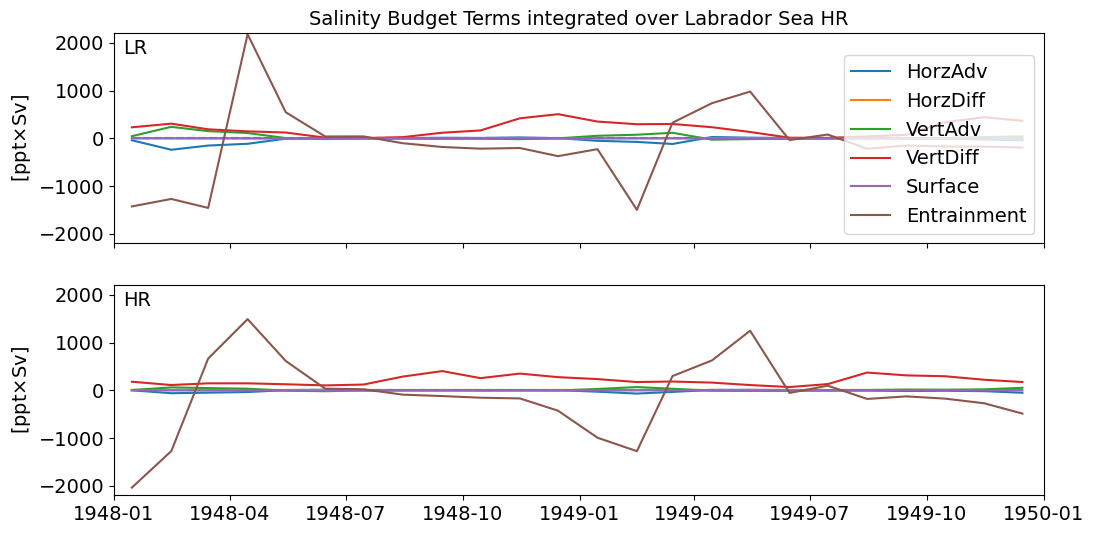

In [36]:
# Plot
names = ['HorzAdv', 'HorzDiff', 'VertAdv', 'VertDiff', 'Surface', 'Entrainment']
time = np.array([datetime(year+1948, month, 15) for year in range(2) for month in range(1, 13)])
fig, axs = plt.subplots(2, 1, figsize=(12, 6))
for ax, meshName in zip(axs, ['LR', 'HR']):
    ax.plot(time[[0, -1]], [0, 0], 'k--')
    for name in names:
        ax.plot(time, outputs[meshName][name] * 1e-6, label=name)
    ax.set_xlim(datetime(1948, 1, 1), datetime(1950, 1, 1))
    ax.set_ylim(-2200, 2200)
    ax.set_ylabel('[ppt$\\times$Sv]')
    ax.text(0.01, 0.9, meshName, transform=ax.transAxes)
axs[0].xaxis.set_ticklabels('')
axs[0].set_title(f'Salinity Budget Terms integrated over Labrador Sea {meshName}')
axs[0].legend(loc=4)

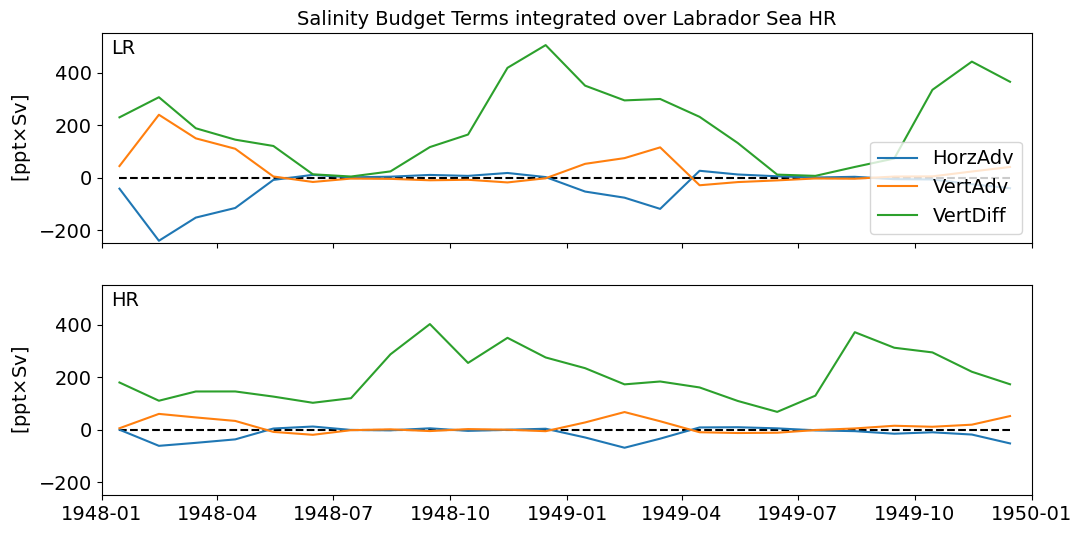

In [34]:
# Plot
names = ['HorzAdv', 'VertAdv', 'VertDiff']
time = np.array([datetime(year+1948, month, 15) for year in range(2) for month in range(1, 13)])
fig, axs = plt.subplots(2, 1, figsize=(12, 6))
for ax, meshName in zip(axs, ['LR', 'HR']):
    ax.plot(time[[0, -1]], [0, 0], 'k--')
    for name in names:
        ax.plot(time, outputs[meshName][name] * 1e-6, label=name)
    ax.set_xlim(datetime(1948, 1, 1), datetime(1950, 1, 1))
    ax.set_ylim(-250, 550)
    ax.set_ylabel('[ppt$\\times$Sv]')
    ax.text(0.01, 0.9, meshName, transform=ax.transAxes)
axs[0].xaxis.set_ticklabels('')
axs[0].set_title(f'Salinity Budget Terms integrated over Labrador Sea {meshName}')
axs[0].legend(loc=4)

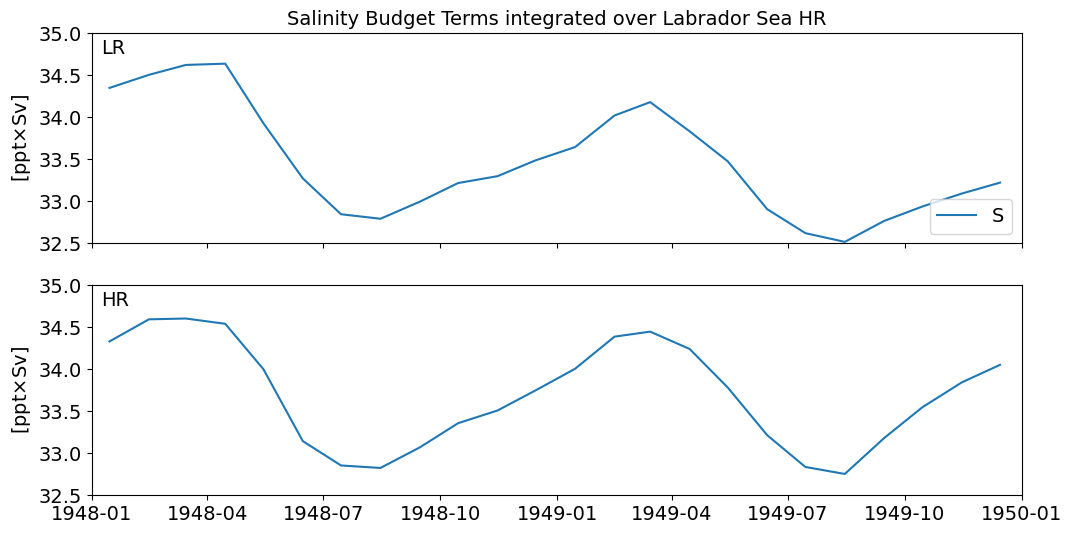

In [40]:
# Plot
time = np.array([datetime(year+1948, month, 15) for year in range(2) for month in range(1, 13)])
fig, axs = plt.subplots(2, 1, figsize=(12, 6))
for ax, meshName in zip(axs, ['LR', 'HR']):
    ax.plot(time, outputs[meshName]['S'] / outputs[meshName]['Volume'], label='S')
    ax.set_xlim(datetime(1948, 1, 1), datetime(1950, 1, 1))
    ax.set_ylim(32.5, 35)
    ax.set_ylabel('[ppt$\\times$Sv]')
    ax.text(0.01, 0.9, meshName, transform=ax.transAxes)
axs[0].xaxis.set_ticklabels('')
axs[0].set_title(f'Salinity Budget Terms integrated over Labrador Sea {meshName}')
axs[0].legend(loc=4)